In [1]:
import torch
from torchdiffeq import odeint
from tqdm.auto import tqdm

In [2]:
class Dynamics(torch.nn.Module):
    def __init__(self, A, B):
        super().__init__()
        self.A = A
        if len(self.A.shape) == 2:
            self.A = self.A.unsqueeze(0)
        self.B = B
        if len(self.B.shape) == 2:
            self.B = self.B.unsqueeze(0)
            
    def forward(self, t, x, u=None):
        dx = A@x
        if u is not None:
            dx += B@u
        return dx
    

In [3]:
class TallNN(torch.nn.Module):
    def __init__(self, max_active_neurons=1000, n_layers=10):
        super().__init__()
        neurons_per_layer = int(max_active_neurons//n_layers)
        input_layer = [torch.nn.Linear(1, neurons_per_layer, 
                                       bias=True), torch.nn.LeakyReLU()]
        intermediate_layers = [
            torch.nn.Linear(neurons_per_layer, 
                            neurons_per_layer, bias=True),
            torch.nn.ELU()
        ]*n_layers
        
        output_layer = [torch.nn.Linear(neurons_per_layer,1,
                                        bias=True)]
        
        self.nn = torch.nn.Sequential(
            *(input_layer+intermediate_layers+output_layer)
        )

        
        
    def forward(self, t, x):
        tt = torch.as_tensor(t).unsqueeze(0).unsqueeze(0)
        dx = self.nn(tt)
        return dx
# interaction matrix
A = torch.tensor([
    [1.]
])

# driver matrix
B = torch.tensor([
    [1.],
])

# total time for control
T = 1
# we evaluate two points in time, first point is matched to initial
# state and  second one is matched to the terminal state
t = torch.linspace(0, T, 100)

# initial state is set as follows, but can be chosen arbirtarily:
x0 = torch.tensor([[
    0.0,
]])

# same applies for target state:
x_target = torch.tensor([[
    1
]])

dyn = Dynamics(A, B)


In [4]:
n_neurons = list(range(10, 100, 10))
n_layers = list(range(1, 10))

In [5]:
all_controls = {}
results = []
for n_lay in tqdm(n_layers):
    for n_neu in tqdm(n_neurons):
        wnn = TallNN(n_neu, n_lay)
        opt = torch.optim.Adam(wnn.parameters(), lr=0.003)
        loss_v = 1
        rerr = 100
        j = 0
        while j < 500:#loss_v > 1e-3  or rerr > 1e-5:
            opt.zero_grad()
            controlled_dyn = lambda tt, y: dyn(tt,y, wnn(tt, None))
            x = odeint(controlled_dyn, x0.unsqueeze(-1), t)
            loss = ((x[-1, :, :].squeeze(-1) - x_target)**2).mean()
            loss.backward()
            rerr = abs(loss_v - loss.item())
            loss_v = loss.item()
            opt.step()
            j+=1
        u = wnn(t.unsqueeze(-1), None)
        all_controls[(n_lay, n_neu)] = u.detach().cpu().numpy()
        #TODO: divide by 2 here
        energy = 0.5*(((u)**2)*0.01).sum().item()
        results.append(dict(n_neurons=n_neu,
                            n_layers = n_lay,
                            energy=energy, 
                            loss=loss_v,
                            mean_control = u.mean().item(),
                            mean_variance = u.var().item()
                            )
                      )

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [6]:
j

500

In [7]:
x_target - x[-1].squeeze(-1)

tensor([[1.1921e-07]], grad_fn=<SubBackward0>)

In [8]:
import numpy as np
0.5*np.trapz(0.01*u.detach().squeeze().numpy()**2, t.numpy())


0.0016938430489972234

In [9]:
(u**2).sum()/2

tensor(16.9384, grad_fn=<DivBackward0>)

In [10]:
baseline_energy = (((-torch.ones_like(u))**2*0.01)).sum()
baseline_energy

tensor(1.)

In [11]:
import pandas as pd
df = pd.DataFrame(results)

In [12]:
df.to_csv('heatmap_linear_1D.csv')

In [13]:
import plotly.express as px

In [14]:
df

n_neurons  n_layers    energy          loss  mean_control  mean_variance
0          10         1  0.175326  9.555379e-11      0.591210   1.134271e-03
1          20         1  0.166230  1.537046e-10      0.575731   1.003835e-03
2          30         1  0.160126  1.547562e-11      0.560740   5.881397e-03
3          40         1  0.179532  6.878054e-12      0.596775   2.952362e-03
4          50         1  0.175987  8.881784e-14      0.592130   1.368736e-03
..        ...       ...       ...           ...           ...            ...
76         50         9  0.169345  0.000000e+00      0.581971   4.113569e-10
77         60         9  0.169567  6.963319e-13      0.582351   1.796928e-06
78         70         9  0.169350  0.000000e+00      0.581979   6.049209e-11
79         80         9  0.169374  1.421085e-14      0.582020   2.429991e-08
80         90         9  0.169384  1.421085e-14      0.582038   4.806967e-08

[81 rows x 6 columns]

In [15]:
hm = df.pivot(index='n_neurons', 
              columns='n_layers', 
              values='energy')
hm2 = df.pivot(index='n_neurons', 
              columns='n_layers', 
               values='loss')
hm3 = df.pivot(index='n_neurons', 
              columns='n_layers', 
               values='mean_control')
hm4 = df.pivot(index='n_neurons', 
              columns='n_layers', 
               values='mean_variance')

In [20]:
f = px.imshow(hm.values, 
          y=hm.index.map(str), 
          x=hm.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                    'color' : 'energy'

                   },
          origin = 'lower'
         )

#f.write_html('energy_heat2.html')
f

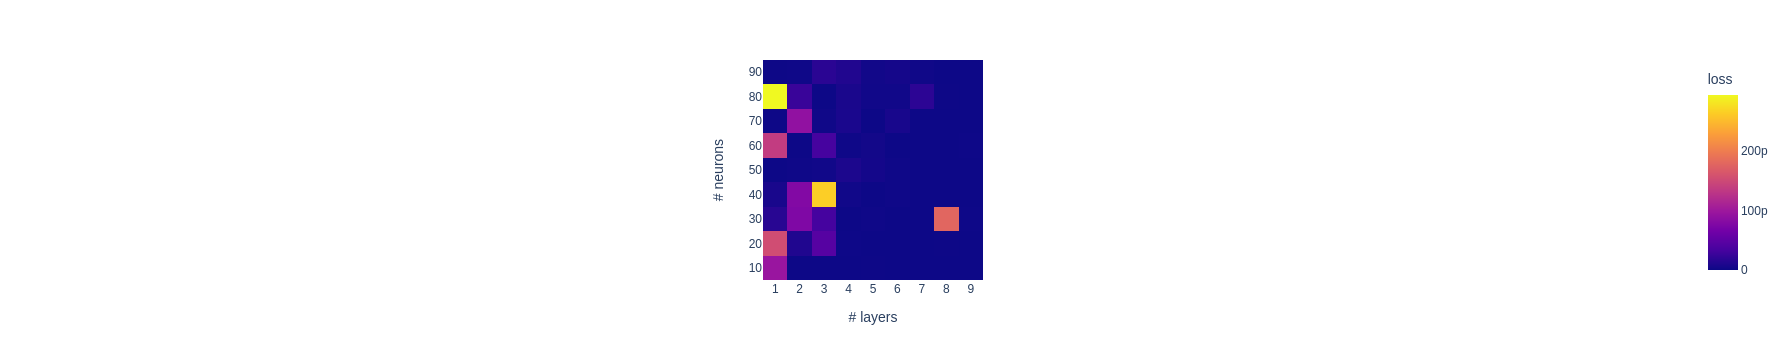

In [17]:
f = px.imshow(hm2.values, 
          y=hm2.index.map(str), 
          x=hm2.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                     'color' : 'loss'
                   },
          origin = 'lower',
         )
#f.write_html('loss_heat2.html')
f

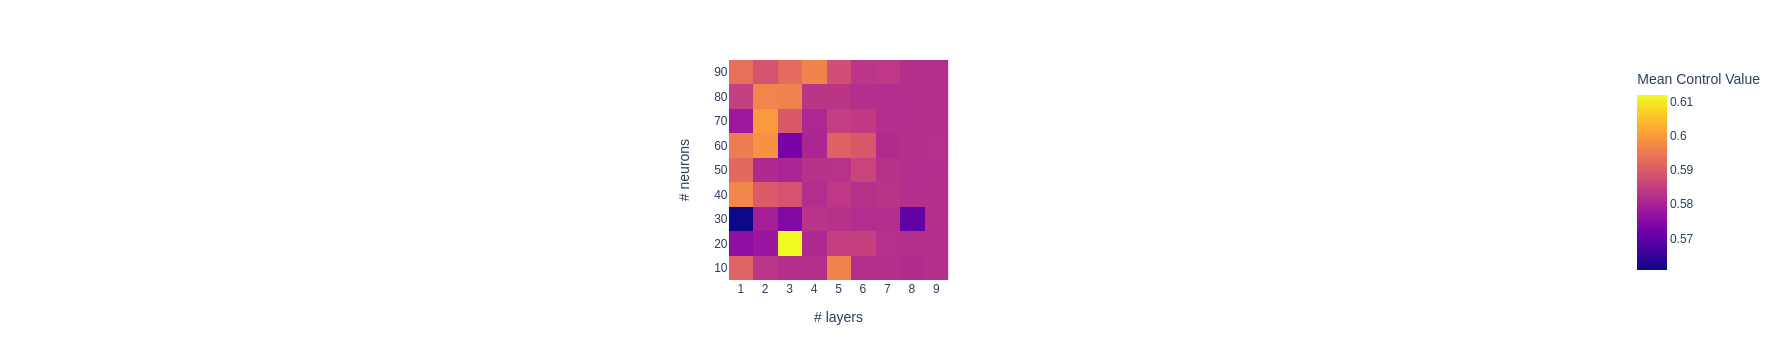

In [18]:
f = px.imshow(hm3.values, 
          y=hm3.index.map(str), 
          x=hm3.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                     'color' : 'Mean Control Value'
                   },
          origin = 'lower',
         )
#f.write_html('mean_control_heat2.html')
f

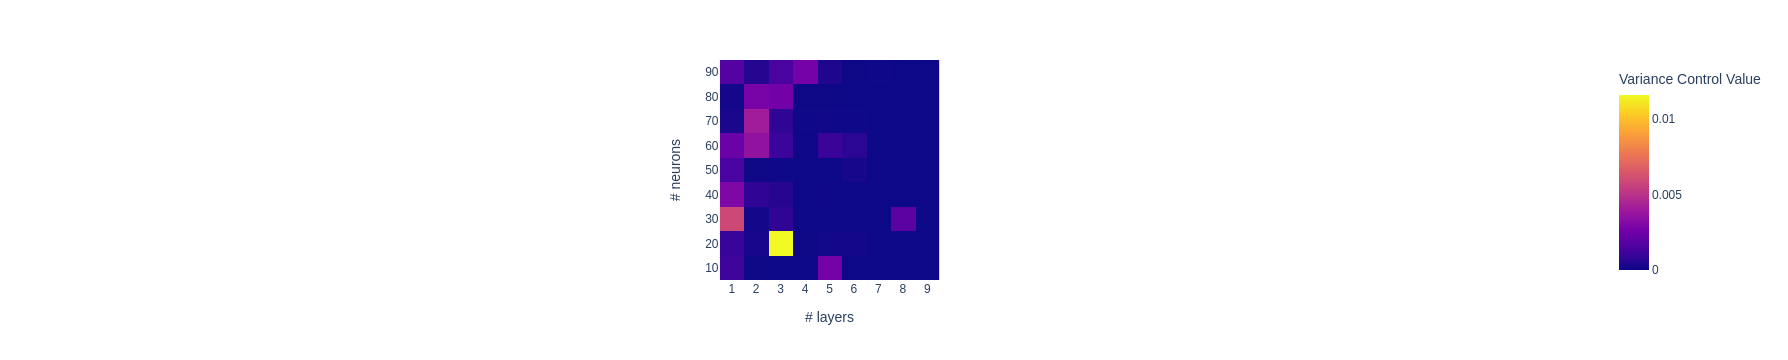

In [19]:
f = px.imshow(hm4.values, 
          y=hm4.index.map(str), 
          x=hm4.columns.map(str),
          labels = {'x' : '# layers',
                    'y' : '# neurons',
                     'color' : 'Variance Control Value'
                   },
          origin = 'lower',
         )
#f.write_html('var_control_heat2.html')
f

In [34]:
px.line(all_controls[(8,30)].squeeze())

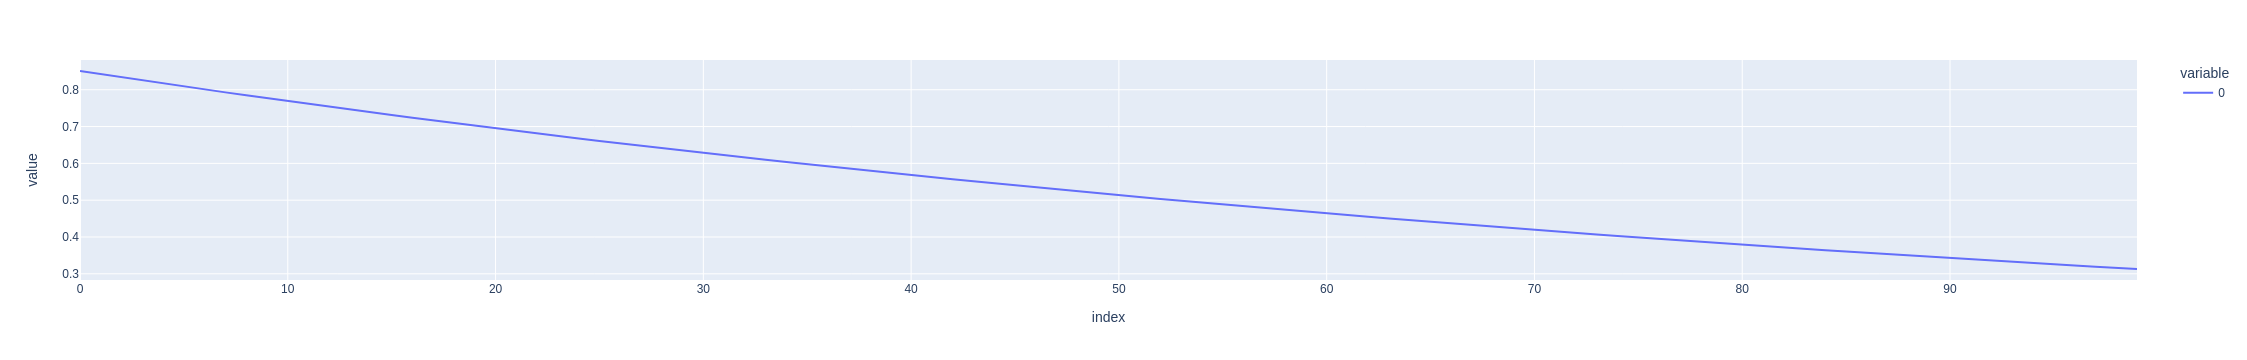

In [30]:
oc = (1*torch.exp(-torch.linspace(0,1, 100))/torch.sinh(torch.ones(1)))*(1-0)
px.line(oc)

In [32]:
(0.01*oc**2).sum()/2

tensor(0.1570)

In [35]:
torch.save(all_controls, 'all_controls_linear1d_dict.pt')